In [1]:
import IPython.core.display as di

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from pylab import show

from bokeh.io import show, output_file
from bokeh.plotting import figure, save
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool, ColumnDataSource
from bokeh.models.graphs import from_networkx, NodesAndLinkedEdges, EdgesAndLinkedNodes
from bokeh.palettes import Spectral4

from IPython.display import IFrame

%matplotlib inline

# read in the pickled graph object and dataframes
G = pd.read_pickle("../data/processed/got_graph.gpickle")

edge = pd.read_csv("../data/processed/character_interactions_edge.csv", sep= ",")
node = pd.read_csv("../data/processed/character_interactions_node.csv", sep= ",")

trim = dict((i,j) for i,j in G.degree().items() if j <= 3)

def trimming(G):
 G_trim = G.copy()
 for k, v in G.degree().items():
  if v <= 3:
   G_trim.remove_node(k)
 return G_trim

G_trim = trimming(G)

# <span style="color:#0000CD"> Community Detection </span>

## Objectives  
### - What is a community?  
### - Cliques  


## <span style="color:#0000CD"> What is a Community? </span>

### Definition

Nodes that can be easily grouped into sets with the potential of overlapping such that each set is densely connected internally form a community. 
<br>
<br>
**Community Detection:** 

&nbsp;&nbsp;&nbsp;&nbsp;The problem of finding natural divisions of a network such that edges within groups are maximized and edges between groups are minimized.

## <span style="color:#0000CD">  Cliques  </span> 

### Definition

A clique is a subset of vertices of an undirected graph such that;
    1) every two vertices are adjacent and 
    2) it forms a complete graph such that every pair of distinct vertices is connected by a unique edge. 
No additional nodes can be added to the subset without making the subgraph less connected.  


<img src="../img/clique.png" width="500">

**Maximal Clique:** 

&nbsp;&nbsp;&nbsp;&nbsp;A clique that cannot be extended by including one more adjacent vertex, meaning it does not exist exclusively within the vertex set of a larger clique.

**Maximum Clique:** 

&nbsp;&nbsp;&nbsp;&nbsp;A clique such that there is no clique with more vertices. 


<img src="../img/maxclique.png" width="500">

###  <span style="color:green">  Knowledge Check: </span>

***Classify the above networks created by the red nodes and edges as maximal or maximum depending on which clique it portrays.***

In [2]:
print("Trimmed Graph Summary:")
print(" ")
print(nx.info(G_trim))

Trimmed Graph Summary:
 
Name: Game of Thrones Character Interactions
Type: Graph
Number of nodes: 377
Number of edges: 2151
Average degree:  11.4111


In [3]:
print("Number of cliques in our trimmed graph:")
cliques = nx.find_cliques(G_trim)
clique_list = list(cliques)
len(clique_list)

Number of cliques in our trimmed graph:


746

In [4]:
print("Maximum clique size:")
nx.graph_clique_number(G_trim)

Maximum clique size:


14

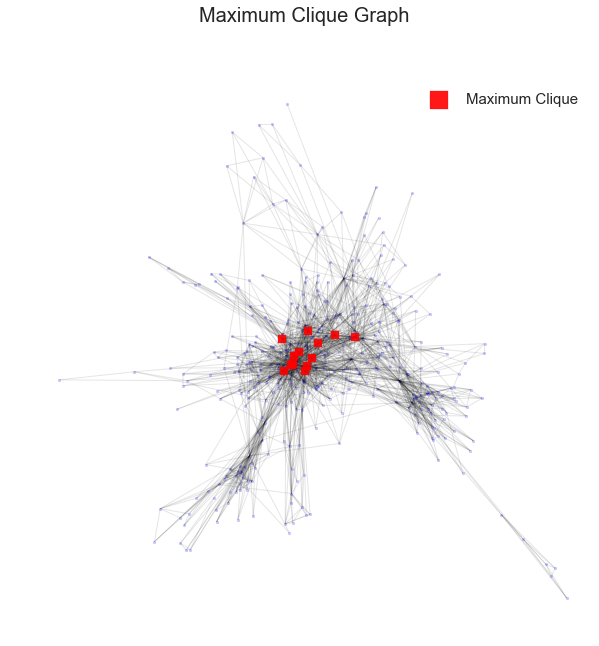

In [5]:
def by_len(grps):
    return [grp for grp in grps if len(grp) == 14]
max_clique = by_len(clique_list)
G_clique = G_trim.subgraph(max_clique[0])

from pylab import show
plt.figure(figsize=(10,10));
plt.suptitle('Maximum Clique Graph', fontsize=20)
plt.autoscale(enable=True, axis='both', tight=True)
plt.axis('off')

# create the layout
spring_pos = nx.fruchterman_reingold_layout(G, scale=2, center=(0,0))

# draw the nodes and the edges (all)
nx.draw_networkx_nodes(G_trim, pos = spring_pos,
                       node_color='b',
                       alpha=0.2,
                       node_size=8)
nx.draw_networkx_edges(G_trim, pos = spring_pos, 
                       alpha=0.1)

# draw the most important nodes with a different style
nx.draw_networkx_nodes(G_clique, pos = spring_pos,
                       label = 'Maximum Clique',
                       node_color='r',
                       alpha=0.9,
                       node_size=75,
                       node_shape='s')
# also the labels this time
#nx.draw_networkx_labels(G_clique, pos = spring_pos,
                        #font_size=12,
                        #font_color=Spectral4[0])
        
plt.legend(numpoints=1, loc='best', markerscale=2, fontsize=15)
plt.show()

In [6]:
print("Maximum Clique Node Table:")
print(" ")
node_trim = pd.DataFrame([i[1] for i in G_trim.nodes(data=True)], index=[i[0] for i in G_trim.nodes(data=True)])
node_trim = node_trim.reset_index()
node_trim = node_trim.rename(columns = {'index': 'Id'})
degree = pd.DataFrame(list(G.degree().items()), columns=['Id','Degree'])
node_trim_degree = pd.merge(node_trim, degree, how = 'left', on = ['Id'])
betweenness = nx.betweenness_centrality(G_trim)
betweenness_df = pd.DataFrame(list(betweenness.items()), columns=['Id','Betweenness'])
node_trim_degree_betweenness = pd.merge(node_trim_degree, betweenness_df, how = 'left', on = ['Id'])
max_clique_df = node_trim_degree_betweenness[node_trim_degree_betweenness['Id'].isin(max_clique[0])]
max_clique_df.sort_values(['Allegiances'])
max_clique_df[['Id','Label','Degree','Betweenness']].sort_values(by=['Label'], ascending = True).reset_index().drop('index',axis=1)

Maximum Clique Node Table:
 


,Id,Label,Degree,Betweenness
0,catelyn-stark,Catelyn Stark,75,0.049472
1,cersei-lannister,Cersei Lannister,97,0.096565
2,eddard-stark,Eddard Stark,74,0.049630
3,jaime-lannister,Jaime Lannister,101,0.081718
4,joffrey-baratheon,Joffrey Baratheon,69,0.034769
5,petyr-baelish,Petyr Baelish,47,0.032587
6,renly-baratheon,Renly Baratheon,38,0.011139
7,robb-stark,Robb Stark,74,0.056787
8,robert-baratheon,Robert Baratheon,65,0.079058
9,sansa-stark,Sansa Stark,75,0.058324


### Advantages

- Clique detection identifies groups that are connected as much as possible which is important for understanding dependencies.

### Disadvantages

- The clique decision problem is [NP-complete](https://en.wikipedia.org/wiki/NP-completeness). 
<br>
<br>
- It is NP meaning there is not a known algorithm for calculating the solution in a polynomial number of steps.
<br>
<br>
- It is also NP-hard because the only known algorithm for identifying cliques tests all possible subsets of the vertices.

## Types of Community Detection

* [Minimum-cut Method](https://www.hackerearth.com/practice/algorithms/graphs/min-cut/tutorial/): calculates the minimum sum of weights of at least one edge that when removed from the graph divides the graph into two groups
<br>
<br>
* [Hierarchical Clustering](http://www.analytictech.com/networks/hiclus.htm): arranges the network into a hierarchy of groups according to a specified weight function
<br>
<br>
* [Girvan-Newman Algorithm](https://en.wikipedia.org/wiki/Girvan%E2%80%93Newman_algorithm): detects communities by focusing on edges that are most likely between communities (i.e. betweenness centrality extended to edges)
<br>
<br>
* [Modularity Maximization](https://www.cs.cmu.edu/~ckingsf/bioinfo-lectures/modularity.pdf): aims to maximize the modularity of a network using a random model of the network and calculaing the probabilities of edges connecting any two nodes

# Conclusion

***Circling back to our goal for the analysis, who have we identified as the most important characters within our data?***

In [7]:
most_popular = dict((i,j) for i,j in G.degree().items() if j >= 40)
G_deg = G_trim.subgraph(most_popular.keys())
most_popular_df = node_trim_degree[node_trim_degree['Id'].isin(G_deg)]
x = most_popular_df[["Id"]]

def max_betweenness(G):
 ranking = betweenness.items()
 r = [x[1] for x in ranking]
 m = sum(r)/len(r) # mean centrality
 t = m*5 # threshold, we keep only the nodes with 5 times the mean
 Gt = G_trim.copy()
 for k, v in ranking:
  if v < t:
   Gt.remove_node(k)
 return Gt
G_bc = max_betweenness(G_trim)
betweenness_centrality_df = node_trim_degree_betweenness[node_trim_degree_betweenness['Id'].isin(G_bc)]
y = betweenness_centrality_df[["Id"]]

z = max_clique_df[["Id"]]

print("Game of Nodes Prediction Table:")
print(" ")
merge_df = pd.merge(x, y, how='outer', on = 'Id')
key_nodes = pd.merge(merge_df, z, how='outer', on = 'Id')
pred = pd.merge(key_nodes, node, how='left', on = 'Id')
pred[pred['Dead'] != 1].sort_values(['Allegiances']).reset_index().drop('index',axis=1)

Game of Nodes Prediction Table:
 


,Id,Label,Allegiances,Gender,Nobility,GoT,CoK,SoS,FfC,DwD,Dead
0,theon-greyjoy,Theon Greyjoy,Greyjoy,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0
1,cersei-lannister,Cersei Lannister,Lannister,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
2,jaime-lannister,Jaime Lannister,Lannister,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
3,tyrion-lannister,Tyrion Lannister,Lannister,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,jon-snow,Jon Snow,Night's Watch,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
5,samwell-tarly,Samwell Tarly,Night's Watch,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
6,petyr-baelish,Petyr Baelish,None,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
7,arya-stark,Arya Stark,Stark,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
8,brienne-of-tarth,Brienne of Tarth,Stark,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
9,bran-stark,Bran Stark,Stark,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0


When we first introduced the data problem, we showed you a relational dataset with nearly 800 different characters and over 2,800 interactions. Our goal was to prove to you that we could key in on the most important individuals in our graph. Through visualization, path analysis, centrality, and community detection, we leave you with the 16 individuals above who we expect to be the key contributors to the plot; that's a 98% reduction in characters!! We hope that these notebooks give you a better understanding of graphs and a new skill or two for your toolbox.